# Nearest neighbour search

## Setting up

In [1]:
import numpy as np
from scipy.spatial import distance
import faiss
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
vector_dimension = 64
num_vectors = 1000000

all_vectors = np.random.random((num_vectors, vector_dimension)).astype('float32')

In [4]:
query_vector = all_vectors[2:3]
num_neighbours = 4

## Exact search

In [5]:
def get_exact_nearest_neighbours(
    query_vector,
    num_neighbours,    
    all_vectors=all_vectors,
    distance_fn=distance.euclidean,
):
    distances = [distance_fn(query_vector, vector) for vector in all_vectors]
        
    sorted_indices = np.argsort(distances)
    
    nearest_indices = sorted_indices[:num_neighbours]
    nearest_distances = np.array(distances)[sorted_indices]
    
    return nearest_distances, nearest_indices

In [6]:
%%time
d, i = get_exact_nearest_neighbours(
    query_vector,
    num_neighbours
)

CPU times: user 23.3 s, sys: 48 ms, total: 23.3 s
Wall time: 23.6 s


In [7]:
d.mean()

3.2575705942099096

In [8]:
i

array([     2, 162565, 516514, 179362])

## Faiss searches

### Brute force L2

https://github.com/facebookresearch/faiss/wiki/Getting-started

In [9]:
bf_index = faiss.IndexFlatL2(vector_dimension)
bf_index.add(all_vectors)
print(f'{bf_index.ntotal} vectors added')

1000000 vectors added


In [10]:
%%time
d, i = bf_index.search(query_vector, num_neighbours)

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 57.5 ms


In [11]:
d.mean()

3.5163112

In [12]:
i

array([[     2, 162565, 516514, 179362]])

### Inverted file with exact post-verification

https://github.com/facebookresearch/faiss/wiki/Faster-search

In [13]:
quantiser = faiss.IndexFlatL2(vector_dimension)
n_cells = 100
if_index = faiss.IndexIVFFlat(quantiser, vector_dimension, n_cells)

if_index.train(all_vectors)
assert if_index.is_trained

if_index.add(all_vectors)
print(f'{if_index.ntotal} vectors added')

1000000 vectors added


In [14]:
%%time
d, i = if_index.search(query_vector, num_neighbours)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 708 µs


In [15]:
d.mean()

3.970962

In [16]:
i

array([[     2, 298105, 806494, 216015]])

### IVFADC (coarse quantizer+PQ on residuals)

https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint

In [17]:
quantiser = faiss.IndexFlatL2(vector_dimension)
n_cells = 100
n_subquantisers = 8
cq_index = faiss.IndexIVFPQ(quantiser, vector_dimension, n_cells, n_subquantisers, 8)

cq_index.train(all_vectors)
assert cq_index.is_trained

cq_index.add(all_vectors)
print(f'{cq_index.ntotal} vectors added')

1000000 vectors added


In [18]:
%%time
d, i = cq_index.search(query_vector, num_neighbours)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 932 µs


In [19]:
d.mean()

3.897607

In [20]:
i

array([[     2, 298105, 770680, 811898]])

## Compairing searches

In [21]:
def time_function_s(function, *args):
    start_time = time.time()
    output = function(*args)
    time_taken = (time.time() - start_time)
    
    return time_taken, output

In [22]:
times = []
mean_distances = []

for function in [
    get_exact_nearest_neighbours,
    bf_index.search,
    if_index.search,
    cq_index.search,
]:
    t, (d, i) = time_function_s(
        function,
        query_vector,
        num_neighbours
    )
    
    times.append(t)
    mean_distances.append(d.mean())

print(times)
print(mean_distances)

[20.37378215789795, 0.13266372680664062, 0.0013682842254638672, 0.00017833709716796875]
[3.2575705942099096, 3.5163112, 3.970962, 3.897607]


In [23]:
time_df = pd.DataFrame({
    'search': ['exact', 'brute force', 'inverted file', 'course quantiser'],
    'time_s': times,
    'mean_distance': mean_distances
})

time_df['log_time_s'] = np.log10(time_df['time_s'])

time_df

,search,time_s,mean_distance,log_time_s
0,exact,20.373782,3.257571,1.309072
1,brute force,0.132664,3.516311,-0.877248
2,inverted file,0.001368,3.970962,-2.863824
3,course quantiser,0.000178,3.897607,-3.748758


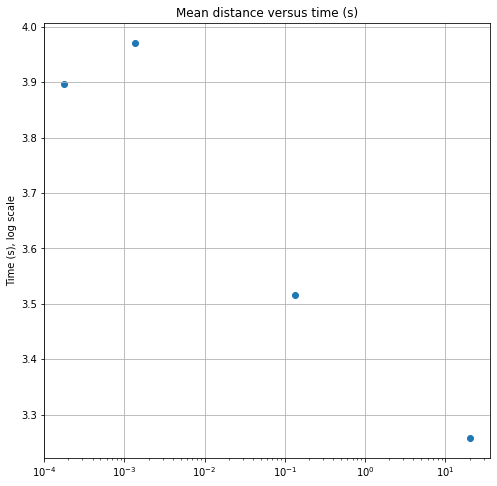

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(
    x=time_df['time_s'],
    y=time_df['mean_distance'],
)
plt.xscale('log')
plt.grid()
plt.title('Mean distance versus time (s)')
plt.ylabel('Mean distance')
plt.ylabel('Time (s), log scale')
plt.show()

# User representations

## Setting up

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Embedding, Dense
import tensorflow_recommenders as tfrs
import random
import psutil 
import gc

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Getting data

### Inspecting data

In [4]:
pd.read_csv("../data/hmdata/articles.csv.zip", nrows=5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
pd.read_csv("../data/hmdata/customers.csv.zip", nrows=5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
pd.read_csv('../data/hmdata/transactions_train.csv.zip', nrows=5)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


### Splitting data

In [7]:
def get_train_test_dates(all_data_df, train_days, test_days):
    
    all_data_df['t_dat'] = pd.to_datetime(all_data_df['t_dat'])
    
    test_end_date = (all_data_df['t_dat'].max() + pd.Timedelta(days=1))
    test_start_date = test_end_date - pd.Timedelta(days=test_days)
    train_start_date = test_start_date - pd.Timedelta(days=train_days)
    
    print('train start date:', train_start_date)
    print('test start date:', test_start_date)
    print('test end date:', test_end_date)
    
    return train_start_date, test_start_date, test_end_date

In [8]:
def get_df(
    start_date,
    end_date
):
    df = all_data_df.loc[
        (all_data_df['t_dat'] >= start_date)
        & (all_data_df['t_dat'] < end_date),
        :
    ]
    
    return df

def get_train_df(train_days, test_days):
    train_start_date, test_start_date, test_end_date = get_train_test_dates(all_data_df, train_days, test_days)
    train_df = get_df(train_start_date, test_start_date)
    
    return train_df

def get_test_df(train_days, test_days):
    train_start_date, test_start_date, test_end_date = get_train_test_dates(all_data_df, train_days, test_days)
    test_df = get_df(test_start_date, test_end_date)
    
    return test_df

### Cleaning data

In [9]:
def clean_article_id(
    df
):
    df = df.copy()
    df['article_id'] = df['article_id'].astype(str)
    # zfill adds zeros (0) at the beginning of the string, until it reaches the specified length
    df['article_id'] = df['article_id'].apply(lambda x: x.zfill(10))
    
    return df

### Munging data

In [10]:
def add_article_features(
    df
):
    df = df.join(
        article_df.set_index('article_id'),
        on='article_id'
    )
    
    return df

In [11]:
def add_customer_features(
    df
):
    df = df.join(
        customer_df.set_index('customer_id'),
        on='customer_id'
    )
    
    return df

In [12]:
def add_features(
    df
):
    df = add_article_features(df)
    df = add_customer_features(df)
    
    return df

### Preparing data

In [13]:
article_df = pd.read_csv("../data/hmdata/articles.csv.zip")
article_df = clean_article_id(article_df)

In [14]:
customer_df = pd.read_csv("../data/hmdata/customers.csv.zip")

In [33]:
all_data_df = pd.read_csv('../data/hmdata/transactions_train.csv.zip')

In [34]:
test_days=30
train_days=180

In [35]:
train_df = get_train_df(train_days, test_days)
train_df = clean_article_id(train_df)
train_df = add_features(train_df)

train_df.head()

train start date: 2020-02-26 00:00:00
test start date: 2020-08-24 00:00:00
test end date: 2020-09-23 00:00:00


,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
22730953,2020-02-26,0004df3751c43c51f79aa24d321f35ce4a1a3ec180c4a1...,0816589003,0.008458,1,816589,Price TEE TVP,255,T-shirt,Garment Upper body,1010008,Front print,10,White,3,Light,9,White,1640,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy,T-shirt in soft cotton jersey with ribbing aro...,NaN,NaN,ACTIVE,NONE,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
22730954,2020-02-26,0004df3751c43c51f79aa24d321f35ce4a1a3ec180c4a1...,0490113020,0.042356,1,490113,Lola RW Denim Shorts,274,Shorts,Garment Lower body,1010016,Solid,72,Blue,2,Medium Dusty,2,Blue,1745,Shorts,D,Divided,2,Divided,53,Divided Collection,1025,Shorts,"Short, 5-pocket shorts in washed, slightly str...",NaN,NaN,ACTIVE,NONE,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
22730955,2020-02-26,0004df3751c43c51f79aa24d321f35ce4a1a3ec180c4a1...,0573085028,0.033881,1,573085,Madison skinny HW,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,5-pocket jeans in washed stretch denim with a ...,NaN,NaN,ACTIVE,NONE,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
22730956,2020-02-26,0004df3751c43c51f79aa24d321f35ce4a1a3ec180c4a1...,0573085043,0.033881,1,573085,Madison skinny HW (1),272,Trousers,Garment Lower body,1010023,Denim,72,Blue,2,Medium Dusty,2,Blue,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,5-pocket jeans in washed stretch denim with a ...,NaN,NaN,ACTIVE,NONE,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
22730957,2020-02-26,0004df3751c43c51f79aa24d321f35ce4a1a3ec180c4a1...,0689365042,0.025407,1,689365,BROADWAY SHIRT S.1,259,Shirt,Garment Upper body,1010004,Check,31,Light Orange,1,Dusty Light,3,Orange,1543,Tops Woven,D,Divided,2,Divided,53,Divided Collection,1010,Blouses,"Shirt in a cotton weave with a collar, buttons...",NaN,NaN,ACTIVE,NONE,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


In [36]:
test_df = get_test_df(train_days, test_days)
test_df = clean_article_id(test_df)
test_df = add_features(test_df)

test_df.head()

train start date: 2020-02-26 00:00:00
test start date: 2020-08-24 00:00:00
test end date: 2020-09-23 00:00:00


,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
30665422,2020-08-24,0000e9a4db2da4e9c68558ad1e7df570d02767b213ec6b...,0880553001,0.025407,2,880553,OP NEW Perth Push,-1,Unknown,Unknown,1010016,Solid,31,Light Orange,1,Dusty Light,3,Orange,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Push-up bra in microfibre with underwired, pad...",1.0,1.0,ACTIVE,Regularly,27.0,de497104dda880ac040e1476cfa3587c405ceb6f53dc53...
30665423,2020-08-24,0000e9a4db2da4e9c68558ad1e7df570d02767b213ec6b...,0880553001,0.025407,2,880553,OP NEW Perth Push,-1,Unknown,Unknown,1010016,Solid,31,Light Orange,1,Dusty Light,3,Orange,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Push-up bra in microfibre with underwired, pad...",1.0,1.0,ACTIVE,Regularly,27.0,de497104dda880ac040e1476cfa3587c405ceb6f53dc53...
30665424,2020-08-24,00047d50bde8751b26aaec7536ccc5fd92828ffa0a396d...,0909081004,0.033881,2,909081,Jessica Long Sweater,252,Sweater,Garment Upper body,1010016,Solid,53,Dark Pink,4,Dark,4,Pink,1647,Tops Knitwear,D,Divided,2,Divided,53,Divided Collection,1003,Knitwear,"Straight-style jumper in a soft, loose knit wi...",NaN,NaN,ACTIVE,NONE,32.0,ff3a08d67de1cc50300128d97ac2961a89330a87a9ad6d...
30665425,2020-08-24,00047d50bde8751b26aaec7536ccc5fd92828ffa0a396d...,0516903024,0.025407,2,516903,Sally Structure TVP,252,Sweater,Garment Upper body,1010026,Other structure,43,Dark Red,4,Dark,18,Red,1647,Tops Knitwear,D,Divided,2,Divided,53,Divided Collection,1003,Knitwear,Jumper in a textured cotton-blend knit with dr...,NaN,NaN,ACTIVE,NONE,32.0,ff3a08d67de1cc50300128d97ac2961a89330a87a9ad6d...
30665426,2020-08-24,00047d50bde8751b26aaec7536ccc5fd92828ffa0a396d...,0897679003,0.042356,2,897679,Vigo Velour Sweater,252,Sweater,Garment Upper body,1010016,Solid,53,Dark Pink,5,Bright,4,Pink,1647,Tops Knitwear,D,Divided,2,Divided,53,Divided Collection,1003,Knitwear,"Jumper in soft, rib-knit chenille with a round...",NaN,NaN,ACTIVE,NONE,32.0,ff3a08d67de1cc50300128d97ac2961a89330a87a9ad6d...


In [37]:
print('number of training samples:', len(train_df))
print('number of test samples:', len(test_df))

number of training samples: 7934469
number of test samples: 1122902


In [38]:
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

del all_data_df
gc.collect()

print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

78.66227408897527
81.7637844025384


In [39]:
# Remove records where we don't have all customer features
train_df = train_df[~train_df['customer_id'].isnull()]
test_df = test_df[~test_df['customer_id'].isnull()]

# Use 100k customers from train_df only so we can quickly test our methods
common_customer_ids = train_df['customer_id'].unique()[:100000]
train_df = train_df[train_df['customer_id'].isin(common_customer_ids)]
test_df = test_df[test_df['customer_id'].isin(common_customer_ids)]

In [40]:
print('number of training samples:', len(train_df))
print('number of test samples:', len(test_df))

number of training samples: 1885955
number of test samples: 228565


In [41]:
all_train_customers = train_df['customer_id'].unique()
all_train_articles = train_df['article_id'].unique()

## Building user representations

### Two tower model

In [42]:
tf.random.set_seed(42)

In [53]:
two_tower_features = [
    'customer_id',
    'article_id'
]

batch_size = 1024


train_ds = tf.data.Dataset.from_tensor_slices(dict(train_df[two_tower_features]))
train_ds = train_ds.shuffle(100_000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(dict(test_df[two_tower_features]))
test_ds = test_ds.batch(batch_size)

In [54]:
two_tower_embedding_dimension = 64

In [55]:
# customer model

customer_model = tf.keras.Sequential([
    StringLookup(vocabulary=all_train_customers, mask_token=None),
    Embedding(input_dim=len(all_train_customers)+1, output_dim=two_tower_embedding_dimension),
    Dense(units=two_tower_embedding_dimension, activation='relu'),
])

In [56]:
# article model

article_model = tf.keras.Sequential([
    StringLookup(vocabulary=all_train_articles, mask_token=None),
    Embedding(input_dim=len(all_train_articles)+1, output_dim=two_tower_embedding_dimension),
    Dense(units=two_tower_embedding_dimension, activation='relu'),
])

In [57]:
class TwoTowerModel(tfrs.Model):

    def __init__(self, customer_model, article_model):
        super().__init__()
        self.customer_model = customer_model
        self.article_model = article_model
        
        self.task = tfrs.tasks.Retrieval(
            num_hard_negatives=5,
        )
    
    def compute_loss(self, features, training=False):
        
        customer_embeddings = self.customer_model(features['customer_id'])
        article_embeddings = self.article_model(features['article_id'])
        
        loss = self.task(
            query_embeddings=customer_embeddings,
            candidate_embeddings=article_embeddings
        )
        
        return loss
        

In [58]:
two_tower_model = TwoTowerModel(customer_model, article_model)
two_tower_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)
)

In [59]:
two_tower_history = two_tower_model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds
)

Epoch 1/5
1842/1842 [==============================] - 40s 21ms/step - loss: 1834.2808 - regularization_loss: 0.0000e+00 - total_loss: 1834.2808 - val_loss: 381.6448 - val_regularization_loss: 0.0000e+00 - val_total_loss: 381.6448
Epoch 2/5
1842/1842 [==============================] - 38s 20ms/step - loss: 1834.2698 - regularization_loss: 0.0000e+00 - total_loss: 1834.2698 - val_loss: 381.6448 - val_regularization_loss: 0.0000e+00 - val_total_loss: 381.6448
Epoch 3/5
1842/1842 [==============================] - 38s 21ms/step - loss: 1834.2698 - regularization_loss: 0.0000e+00 - total_loss: 1834.2698 - val_loss: 381.6448 - val_regularization_loss: 0.0000e+00 - val_total_loss: 381.6448
Epoch 4/5
1842/1842 [==============================] - 38s 21ms/step - loss: 1834.2698 - regularization_loss: 0.0000e+00 - total_loss: 1834.2698 - val_loss: 381.6448 - val_regularization_loss: 0.0000e+00 - val_total_loss: 381.6448
Epoch 5/5
1842/1842 [==============================] - 38s 20ms/step - loss:

In [50]:
customer_model(tf.constant([all_train_customers[0]]))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 0.02536211, -0.01378656,  0.00116325,  0.02272798, -0.01370389,
         0.01487025,  0.00204682, -0.00018618, -0.0032585 , -0.00509635,
        -0.00828261,  0.00440217, -0.00695073,  0.00689864,  0.00208603,
         0.01149466, -0.012302  , -0.00130026, -0.00402368,  0.00037299,
        -0.00702857,  0.00050654,  0.00406604,  0.01627924,  0.00156163,
        -0.00060795,  0.03074044, -0.00851901,  0.01108615, -0.01752133,
         0.01654533, -0.03222105,  0.01194486, -0.00587823, -0.02202146,
        -0.00021719,  0.01019189,  0.01941377, -0.0003774 , -0.01424251,
        -0.01926081,  0.00084376, -0.01693742, -0.00150464, -0.00831177,
        -0.03129398,  0.01220438, -0.01574803, -0.01593511, -0.0088499 ,
         0.03032324,  0.00798321, -0.00517444,  0.02660541, -0.00733474,
         0.02132154, -0.01550486, -0.0105623 ,  0.00052506,  0.04449499,
         0.0189954 , -0.00336749,  0.00025124,  0.03894971]],
      dtype=f

In [51]:
customer_model(tf.constant([all_train_customers[1]]))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[-0.01539883, -0.00512623,  0.01163026,  0.01594151, -0.00320897,
         0.00022982,  0.00490301, -0.01470087,  0.00319173, -0.00012435,
         0.01229922,  0.01882054, -0.00958228, -0.01832684,  0.003985  ,
         0.00566011, -0.01244579, -0.00602639, -0.00443584,  0.01349682,
        -0.00416035, -0.01525928,  0.01253911, -0.00848813,  0.00661951,
        -0.0093028 , -0.00566288,  0.01653449, -0.02358476, -0.00634257,
         0.01085565, -0.01505036,  0.01797305, -0.01877346,  0.00820072,
        -0.01826585,  0.00133742, -0.01861474,  0.00844481, -0.00430371,
        -0.00713054,  0.00698882, -0.0342593 , -0.00595086,  0.00035011,
         0.00981082,  0.00527436, -0.00881314, -0.00442366,  0.01007136,
         0.00676754, -0.01001105,  0.008569  ,  0.00223254,  0.01426498,
        -0.01068327, -0.00925781, -0.00206809,  0.01065513,  0.02859727,
        -0.00523481, -0.02369767, -0.00439469,  0.02442637]],
      dtype=f